In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix, accuracy_score

In [ ]:
import pandas as pd
df = pd.read_csv('youth_data.csv')
df.columns = df.columns.str.upper()
df.head()


,IRALCFY,IRMJFY,IRCIGFM,IRSMKLSS30N,IRALCFM,IRMJFM,IRCIGAGE,IRSMKLSSTRY,IRALCAGE,IRMJAGE,...,EDUSCHLGO,EDUSCHGRD2,EDUSKPCOM,IMOTHER,IFATHER,INCOME,GOVTPROG,POVERTY3,PDEN10,COUTYP4
0,991,991,91.0,91,91.0,91.0,991,991,991,991,...,1,3,0,1,1,2,2,1,2,2
1,991,60,91.0,91,91.0,2.0,991,991,991,14,...,1,6,0,1,1,2,2,1,2,2
2,1,991,91.0,91,93.0,91.0,991,991,11,991,...,1,2,1,1,1,4,2,3,1,1
3,991,991,91.0,91,91.0,91.0,991,991,991,991,...,1,2,0,1,1,3,2,2,1,1
4,991,991,91.0,91,91.0,91.0,991,991,991,991,...,1,5,0,1,1,4,2,3,2,2


In [ ]:

missing_values = df.isnull().sum()

In [ ]:
print(missing_values)

IRALCFY        0
IRMJFY         0
IRCIGFM        0
IRSMKLSS30N    0
IRALCFM        0
              ..
INCOME         0
GOVTPROG       0
POVERTY3       0
PDEN10         0
COUTYP4        0
Length: 79, dtype: int64


In [ ]:

# Substance-related variables
substance_cols = [
    'IRALCFY', 'IRMJFY', 'IRCIGFM', 'IRSMKLSS30N', 'IRALCFM', 'IRMJFM',
    'IRCIGAGE', 'IRSMKLSSTRY', 'IRALCAGE', 'IRMJAGE',
    'MRJFLAG', 'ALCFLAG', 'TOBFLAG',
    'ALCYDAYS', 'MRJYDAYS', 'ALCMDAYS', 'MRJMDAYS', 'CIGMDAYS', 'SMKLSMDAYS'
]

In [ ]:
# Demographics
demographic_cols = [
    'IRSEX', 'NEWRACE2', 'HEALTH2', 'EDUSCHLGO', 'EDUSCHGRD2', 'EDUSKPCOM',
    'IMOTHER', 'IFATHER', 'INCOME', 'GOVTPROG', 'POVERTY3', 'PDEN10', 'COUTYP4'
]
df_demograpic = df[demographic_cols]
# Youth experience columns: from SCHFELT to RLGFRND
youth_start = df.columns.get_loc('SCHFELT')
youth_end = df.columns.get_loc('RLGFRND')
youth_experience_cols = df.columns[youth_start:youth_end+1].tolist()


In [ ]:
df.dropna(subset=youth_experience_cols, inplace=True)
df.shape

(8252, 79)

# Finding Correlation among variables

In [ ]:


# Step 1: Load data (assuming df is already loaded and filtered)
df_youth = df.loc[:, 'SCHFELT':'RLGFRND']  # Adjust if your youth columns differ
df_corr = df_youth.copy()
df_corr["MRJFLAG"] = df["MRJFLAG"]

# Step 2: Encode all categorical variables
df_corr = df_corr.apply(lambda col: pd.factorize(col)[0] if col.dtypes == 'object' or col.dtypes.name == 'category' else col)

# Step 3: Compute correlations
correlations = df_corr.corr()["MRJFLAG"].drop("MRJFLAG").sort_values(ascending=False)

# Step 4: Display top and bottom correlations
print("\n Top correlated features with MRJFLAG:")
print(correlations.head(10))

print("\n Least correlated features with MRJFLAG:")
print(correlations.tail(10))



 Top correlated features with MRJFLAG:
FRDMJMON    0.457477
YFLMJMO     0.432293
FRDMEVR2    0.422912
YFLTMRJ2    0.404825
PRMJMO      0.361466
PRMJEVR2    0.360204
FRDADLY2    0.192294
YFLADLY2    0.179669
PRPROUD2    0.152068
PRLMTTV2    0.146856
Name: MRJFLAG, dtype: float64

 Least correlated features with MRJFLAG:
YOHGUN2    -0.110776
YOGRPFT2   -0.112483
AVGGRADE   -0.113435
YOFIGHT2   -0.124345
YOATTAK2   -0.129681
STNDDNK    -0.206776
YOSELL2    -0.211036
YOSTOLE2   -0.227884
STNDALC    -0.284799
STNDSMJ    -0.402765
Name: MRJFLAG, dtype: float64


In [ ]:
#drop . from dataframe

df = df[df != '.'].dropna()

# Binary Classification

Only those correlated variables which has correlation > 20


In [ ]:
#Filter correlations > 0.20 or < -0.20
strong_correlations = correlations[correlations > 0.20]
strong_correlations

,MRJFLAG
FRDMJMON,0.457477
YFLMJMO,0.432293
FRDMEVR2,0.422912
YFLTMRJ2,0.404825
PRMJMO,0.361466
PRMJEVR2,0.360204


FRDMJMON : CLSE FRNDS FEEL ABT YTH USE MARIJUANA MON

YFLMJMO: HOW YTH FEELS: PEERS USING MARIJUANA MONTHLY

FRDMEVR2: -YTH THINK: CLOSE FRNDS FEEL ABT YTH TRY MARIJUANA

YFLTMRJ2: -HOW YTH FEELS: PEERS TRY MARIJUANA

PRMJMO: -YTH THINK: PARENTS FEEL ABT YTH USE MARIJUANA MNTHLY

PRMJEVR2: YTH THINK: PARENTS FEEL ABT YTH TRY MARIJUANA

The following indicators are highly correlated to the target variavble which is MRJFLAG. It means the peer indicators and parental indicators have influenced on the youth if they have ever usd marijuana


## Decision Tree

Whether their friends or peers use marijuana

 Decision Tree Results
Accuracy: 0.7458585858585859
Confusion Matrix:
 [[1534  539]
 [  90  312]]
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.74      0.83      2073
           1       0.37      0.78      0.50       402

    accuracy                           0.75      2475
   macro avg       0.66      0.76      0.66      2475
weighted avg       0.85      0.75      0.78      2475



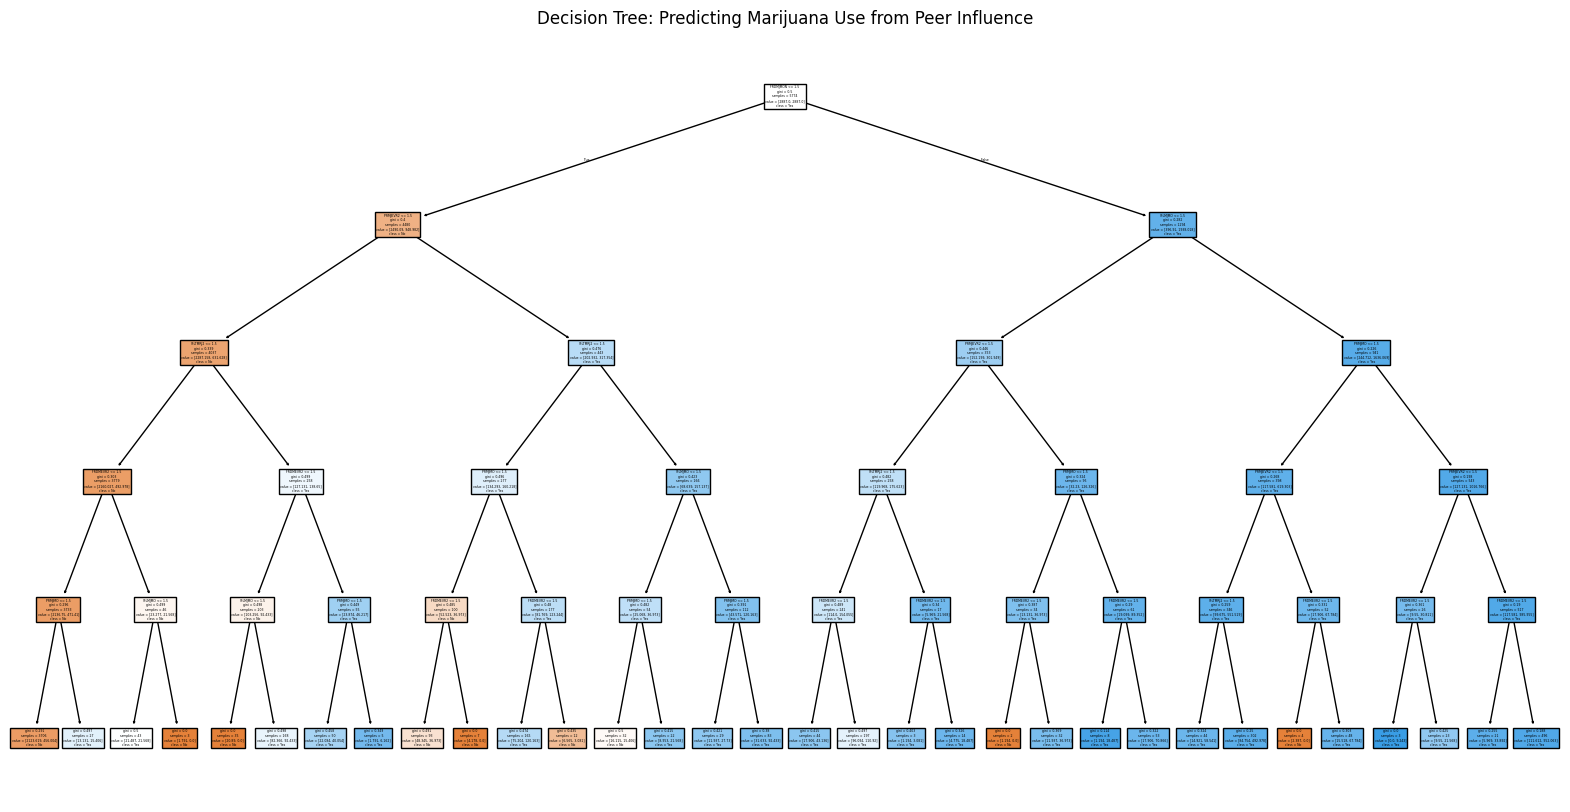

In [ ]:
# === Filter to those who answered youth experience questions ===
df = df[df['SCHFELT'].notna()].copy()

# === Define peer influence features ===
peer_features = ['FRDMJMON', 'YFLMJMO', 'FRDMEVR2', 'YFLTMRJ2', 'PRMJMO','PRMJEVR2']

# === Target variable ===
target = 'MRJFLAG'

# === Drop rows with missing values in selected features or target ===
df_model = df[peer_features + [target]].dropna()

# === Convert to numeric if needed (factorization for categorical) ===
for col in peer_features:
    if df_model[col].dtype == 'object':
        df_model[col] = pd.factorize(df_model[col])[0]

# === Define X and y ===
X = df_model[peer_features]
y = df_model[target]

# === Train/test split ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=42
)

# === Fit decision tree ===
dt = DecisionTreeClassifier(max_depth=5, random_state=42, class_weight="balanced")
dt.fit(X_train, y_train)

# === Predict ===
y_pred = dt.predict(X_test)

# === Evaluate ===
print(" Decision Tree Results")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# === Plot the tree ===
plt.figure(figsize=(20, 10))
plot_tree(dt, feature_names=peer_features, class_names=["No", "Yes"], filled=True)
plt.title("Decision Tree: Predicting Marijuana Use from Peer Influence")
plt.show()

This tree is answering:

Can we reasonably predict if a youth used marijuana recently based on peer influence, using a simple model?

Answer: Yes, to a good extent. Your model has decent accuracy and is fair at identifying users.

## Pruned Tree

Pruned Decision Tree Results
Best Parameters: {'max_depth': 4, 'min_samples_leaf': 1}
Accuracy: 0.7802020202020202
Confusion Matrix:
 [[1635  438]
 [ 106  296]]
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.79      0.86      2073
           1       0.40      0.74      0.52       402

    accuracy                           0.78      2475
   macro avg       0.67      0.76      0.69      2475
weighted avg       0.85      0.78      0.80      2475



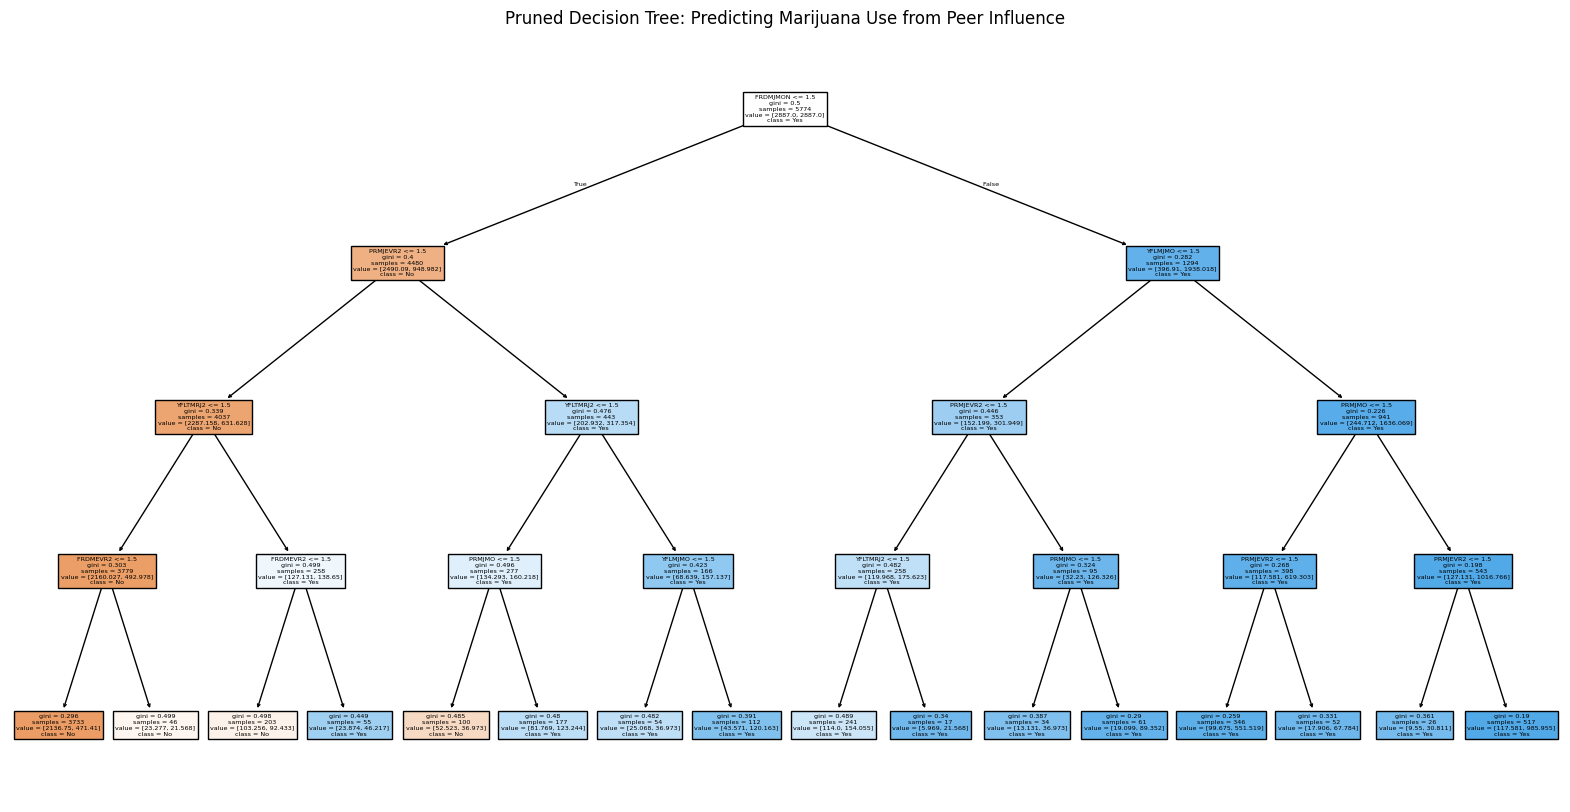

In [ ]:

df_model = df[peer_features + [target]].dropna()


X = df_model[peer_features]
y = df_model[target]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=42
)

# === Pruning with GridSearchCV ===
param_grid = {'max_depth': range(2, 15), 'min_samples_leaf': [1, 5, 10]}
grid = GridSearchCV(
    DecisionTreeClassifier(random_state=42, class_weight="balanced"),
    param_grid,
    cv=5,
    scoring='f1',  # F1 balances precision and recall for class 1
    n_jobs=-1
)
grid.fit(X_train, y_train)

# Best model
best_dt = grid.best_estimator_

# Evaluation
y_pred = best_dt.predict(X_test)

print("Pruned Decision Tree Results")
print("Best Parameters:", grid.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Plot tree
plt.figure(figsize=(20, 10))
plot_tree(best_dt, feature_names=peer_features, class_names=["No", "Yes"], filled=True)
plt.title("Pruned Decision Tree: Predicting Marijuana Use from Peer Influence")
plt.show()

Can we build a balanced, interpretable model to predict recent youth marijuana use based on peer influence factors?

Yes — this pruned tree gives you:

Strong recall for identifying users (important if the goal is early intervention)

Good accuracy and interpretability

Less overfitting compared to a deep tree

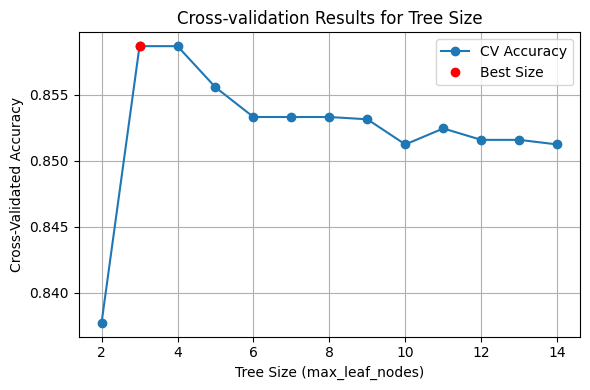

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

# Define parameter grid
params = {'max_leaf_nodes': range(2, 15)}

# Set up GridSearchCV
grid = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_grid=params,
    cv=5,
    scoring='accuracy',
    return_train_score=True
)

# Fit the grid search
grid.fit(X_train, y_train)

# Get best parameters and score
best_size = grid.best_params_['max_leaf_nodes']
best_score = grid.best_score_

# Plot results
plt.figure(figsize=(6, 4))
plt.plot(grid.cv_results_['param_max_leaf_nodes'], grid.cv_results_['mean_test_score'], 'o-', label='CV Accuracy')
plt.plot(best_size, best_score, 'ro', label='Best Size')
plt.xlabel('Tree Size (max_leaf_nodes)')
plt.ylabel('Cross-Validated Accuracy')
plt.title('Cross-validation Results for Tree Size')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# === Use the same X and y from earlier ===
# (X, y already filtered, encoded, and split from pruned tree code)

# === Random Forest with Grid Search ===
rf_params = {'n_estimators': [100], 'max_depth': [3, 6, 9]}
rf_model = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid=rf_params,
    scoring='f1',
    cv=5,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

print("\n Random Forest Results")
print("Best Parameters:", rf_model.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))



 Random Forest Results
Best Parameters: {'max_depth': 6, 'n_estimators': 100}
Accuracy: 0.84
Confusion Matrix:
 [[1904  169]
 [ 227  175]]
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.92      0.91      2073
           1       0.51      0.44      0.47       402

    accuracy                           0.84      2475
   macro avg       0.70      0.68      0.69      2475
weighted avg       0.83      0.84      0.83      2475



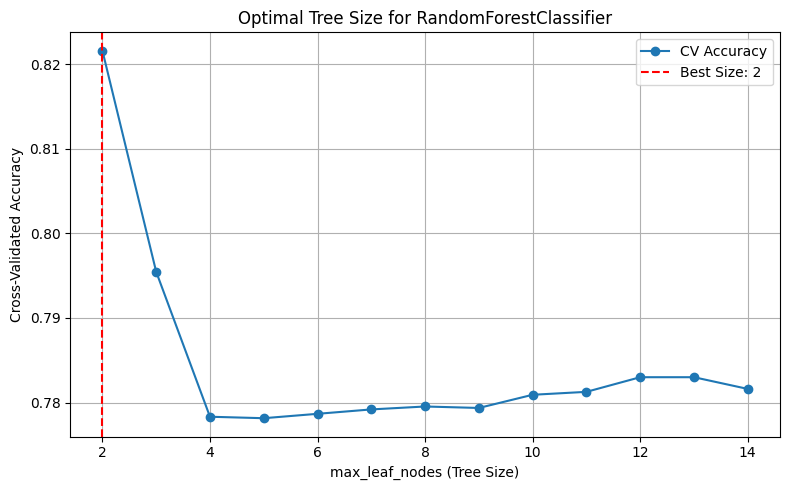

Best Tree Size (max_leaf_nodes): 2
Best Cross-Validated Accuracy: 0.8216


In [ ]:
# Define parameter grid for max_leaf_nodes
param_grid = {'max_leaf_nodes': range(2, 15)}

# Initialize GridSearchCV
grid = GridSearchCV(
    estimator=RandomForestClassifier(
        n_estimators=100,
        random_state=42,
        class_weight="balanced"  # Optional, if data is imbalanced
    ),
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    return_train_score=True
)

# Fit to training data
grid.fit(X_train, y_train)

# Extract best params and score
best_size = grid.best_params_['max_leaf_nodes']
best_score = grid.best_score_

# Plot cross-validation accuracy vs tree size
plt.figure(figsize=(8, 5))
plt.plot(grid.cv_results_['param_max_leaf_nodes'], grid.cv_results_['mean_test_score'], marker='o', label='CV Accuracy')
plt.axvline(best_size, color='red', linestyle='--', label=f'Best Size: {best_size}')
plt.xlabel('max_leaf_nodes (Tree Size)')
plt.ylabel('Cross-Validated Accuracy')
plt.title('Optimal Tree Size for RandomForestClassifier')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print best result
print(f"Best Tree Size (max_leaf_nodes): {best_size}")
print(f"Best Cross-Validated Accuracy: {best_score:.4f}")

## Gradient Boosting

In [ ]:
# === Gradient Boosting with Grid Search ===
gb_params = {'learning_rate': [0.01, 0.05], 'n_estimators': [100, 200], 'max_depth': [3, 5]}
gb_model = GridSearchCV(
    GradientBoostingClassifier(random_state=42),
    param_grid=gb_params,
    scoring='f1',
    cv=5,
    n_jobs=-1
)
gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)

print("\n Gradient Boosting Results")
print("Best Parameters:", gb_model.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred_gb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_gb))
print("Classification Report:\n", classification_report(y_test, y_pred_gb))


 Gradient Boosting Results
Best Parameters: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200}
Accuracy: 0.8408080808080808
Confusion Matrix:
 [[1907  166]
 [ 228  174]]
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.92      0.91      2073
           1       0.51      0.43      0.47       402

    accuracy                           0.84      2475
   macro avg       0.70      0.68      0.69      2475
weighted avg       0.83      0.84      0.84      2475



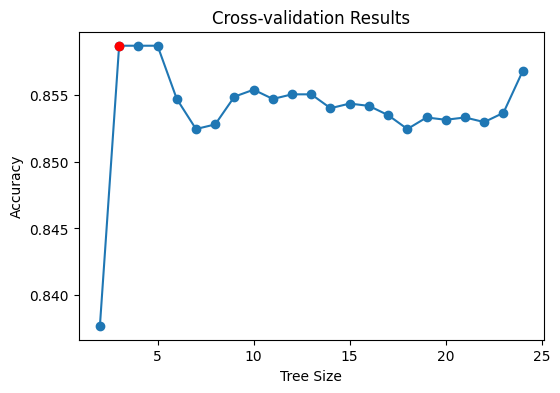

In [ ]:
tree_ = DecisionTreeClassifier(random_state=1)
tree_.fit(X_train, y_train)
params = {'max_leaf_nodes': range(2, 25)}
cv = GridSearchCV(tree_, params, cv=10)
cv.fit(X_train, y_train)
cv_results = cv.cv_results_
best_size = cv.best_params_['max_leaf_nodes']
best_score = cv.best_score_
plt.figure(figsize=(6, 4))
plt.plot(cv_results["param_max_leaf_nodes"], cv_results["mean_test_score"], 'o-')
plt.plot(best_size, best_score, 'ro-')
plt.xlabel('Tree Size')
plt.ylabel('Accuracy')
plt.title('Cross-validation Results');


## Bagging

In [ ]:
X = df_model[peer_features]
y = df_model[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=42
)

# Fit Bagging model (Random Forest)
bagging_model = RandomForestClassifier(
    max_features=X_train.shape[1],
    n_estimators=25,
    random_state=1,
    class_weight="balanced"
)

bagging_model.fit(X_train, y_train)

# Predictions
y_pred = bagging_model.predict(X_test)
y_proba = bagging_model.predict_proba(X_test)[:, 1]

# Evaluation
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error: {:.2f}".format(mse))
print("Number of trees:", bagging_model.n_estimators)
print("Number of features tried at each split:", bagging_model.max_features)
print("Training score: {:.2f}%".format(bagging_model.score(X_train, y_train) * 100))
print("Test score: {:.2f}%".format(bagging_model.score(X_test, y_test) * 100))

# Classification report using thresholded probabilities
y_pred_thresh = (y_proba > 0.5).astype(int)
print(classification_report(y_test, y_pred_thresh))

Mean Squared Error: 0.26
Number of trees: 25
Number of features tried at each split: 6
Training score: 78.13%
Test score: 74.46%
              precision    recall  f1-score   support

           0       0.94      0.74      0.83      2073
           1       0.36      0.77      0.49       402

    accuracy                           0.74      2475
   macro avg       0.65      0.75      0.66      2475
weighted avg       0.85      0.74      0.77      2475



In [ ]:
np.bincount(y_train)  # or pd.Series(y_train).value_counts()


array([4837,  937])

The training data is heavily imbalanced:

Class 0: 4,837 samples

Class 1: 937 samples
So, ~84% of your data is Class 0.

# Multi class Classification

## Decision Tree

# Finding Correlation among variables

In [ ]:
# Step 1: Load data (assuming df is already loaded and filtered)
df_youth = df.loc[:, 'SCHFELT':'RLGFRND']  # Adjust if your youth columns differ
df_corr = df_youth.copy()
df_corr["MRJYDAYS"] = df["MRJYDAYS"]

# Step 2: Encode all categorical variables
df_corr = df_corr.apply(lambda col: pd.factorize(col)[0] if col.dtypes == 'object' or col.dtypes.name == 'category' else col)

# Step 3: Compute correlations
correlations = df_corr.corr()["MRJYDAYS"].drop("MRJYDAYS").sort_values(ascending=False)

# Step 4: Display top and bottom correlations
print("\n Top correlated features with MRJYDAYS:")
print(correlations.head(10))

print("\n Least correlated features with MRJYDAYS:")
print(correlations.tail(10))


 Top correlated features with MRJYDAYS:
STNDSMJ     0.320484
STNDALC     0.231410
YOSTOLE2    0.171206
STNDDNK     0.141846
YOSELL2     0.127790
YOATTAK2    0.097001
YOFIGHT2    0.090041
YOGRPFT2    0.082591
YOHGUN2     0.078604
AVGGRADE    0.074064
Name: MRJYDAYS, dtype: float64

 Least correlated features with MRJYDAYS:
PRGDJOB2   -0.123844
PRPROUD2   -0.124676
YFLADLY2   -0.133735
FRDADLY2   -0.140972
PRMJMO     -0.277249
PRMJEVR2   -0.283601
YFLTMRJ2   -0.336232
FRDMEVR2   -0.345538
YFLMJMO    -0.358430
FRDMJMON   -0.372698
Name: MRJYDAYS, dtype: float64


In [ ]:
strong_correlations = correlations[correlations > 0.10]
strong_correlations

,MRJYDAYS
STNDSMJ,0.320484
STNDALC,0.231410
YOSTOLE2,0.171206
STNDDNK,0.141846
YOSELL2,0.127790


STNDSMJ: Perceived risk of using marijuana regularly.

STNDALC: Perceived risk of using alcohol regularly

The above two indicators are highly correlated with MRJYDAYS

"In this multiclass classification task, we aim to predict the frequency of marijuana use (MRJYDAYS) among youth using their perceived risk of marijuana (STNDSMJ) and alcohol (STNDALC). The goal is to understand how substance risk perception correlates with actual usage behavior and whether these insights can guide prevention strategies."

In [ ]:
# Step 1: Define the mapping
def remap_mrjydays(value):
    if value in [1, 2]:
        return 0  # light
    elif value in [3, 4]:
        return 1  # moderate
    elif value in [5, 6]:
        return 2  # heavy
# === Define peer influence features ===
features = ['STNDSMJ', 'STNDALC', 'YOSTOLE2', 'STNDDNK','YOSELL2'	]

# Step 2: Create the model DataFrame (subset + dropna first)
df_model = df[features + ['MRJYDAYS']].dropna()

# Step 3: Apply the mapping
df_model['MRJYDAYS'] = df_model['MRJYDAYS'].apply(remap_mrjydays)

# Step 4: Factorize categorical columns
for col in features:
    if df_model[col].dtype == 'object':
        df_model[col] = pd.factorize(df_model[col])[0]

# Step 5: Define features and target
X = df_model[features]
y = df_model['MRJYDAYS']

Decision Tree Results
Accuracy: 0.6424242424242425
Confusion Matrix:
 [[  95   52   45]
 [  48   42   23]
 [ 540  177 1453]]
Classification Report:
               precision    recall  f1-score   support

           0       0.14      0.49      0.22       192
           1       0.15      0.37      0.22       113
           2       0.96      0.67      0.79      2170

    accuracy                           0.64      2475
   macro avg       0.42      0.51      0.41      2475
weighted avg       0.86      0.64      0.72      2475



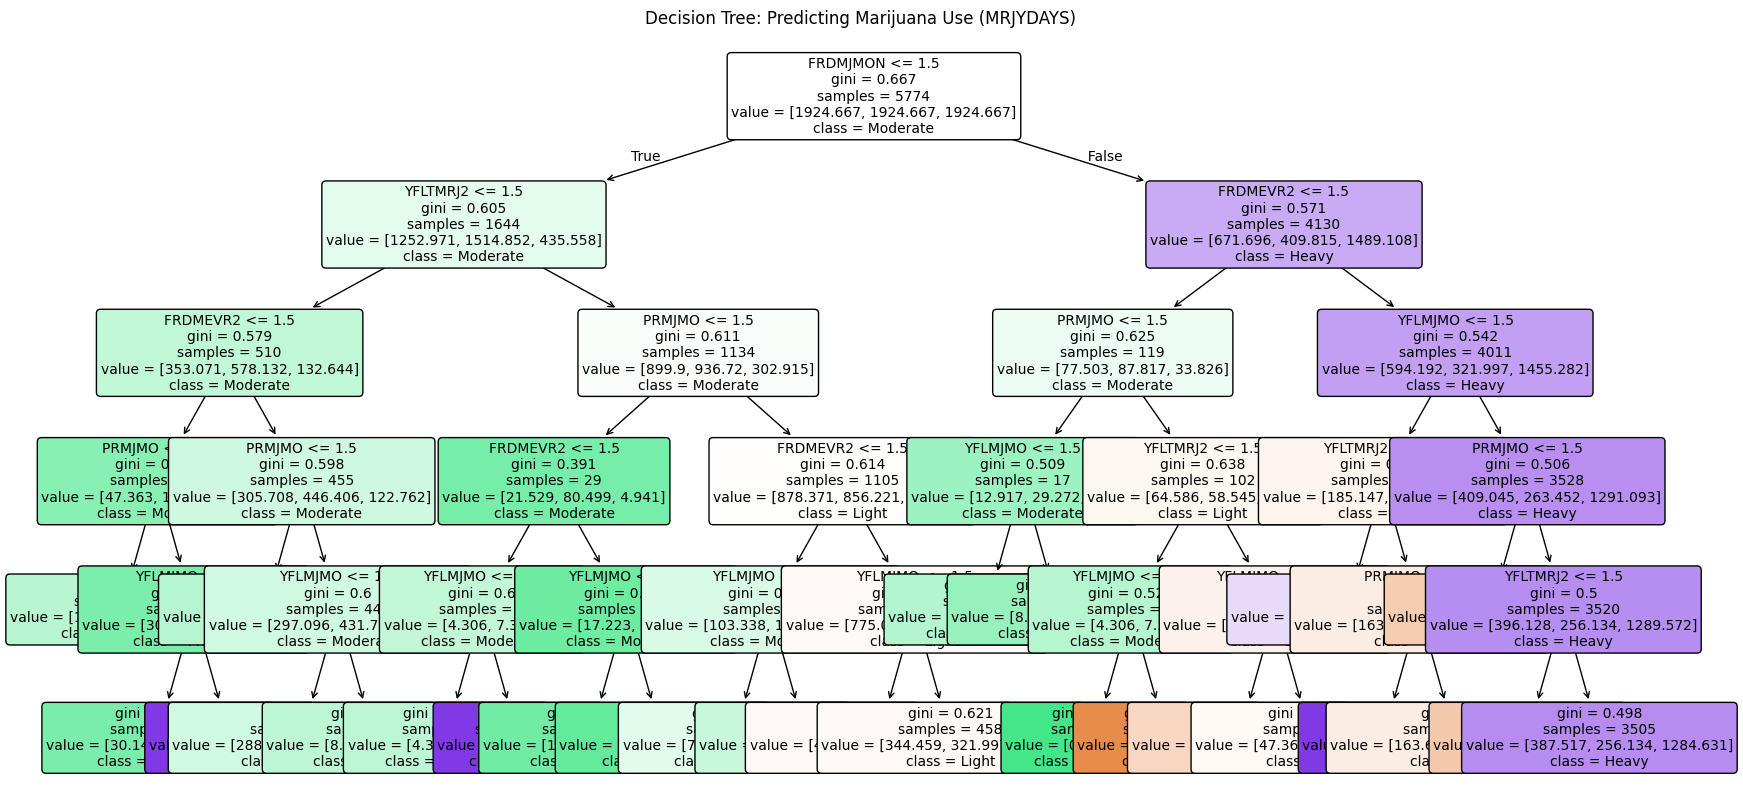

In [ ]:

# === Train/test split ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=42
)

# === Fit decision tree ===
dt = DecisionTreeClassifier(max_depth=5, class_weight="balanced", random_state=42)
dt.fit(X_train, y_train)

# === Predict ===
y_pred = dt.predict(X_test)

# === Evaluate ===
print("Decision Tree Results")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# === Plot the tree ===
# Convert class labels to string to display in the tree
class_labels = ['Light', 'Moderate', 'Heavy']

plt.figure(figsize=(20, 10))
plot_tree(
    dt,
    feature_names=peer_features,
    class_names=class_labels,
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("Decision Tree: Predicting Marijuana Use (MRJYDAYS)")
plt.show()

model is heavily biased toward the majority class (class 2: Heavy users). This is very common when you have class imbalance in the target variable



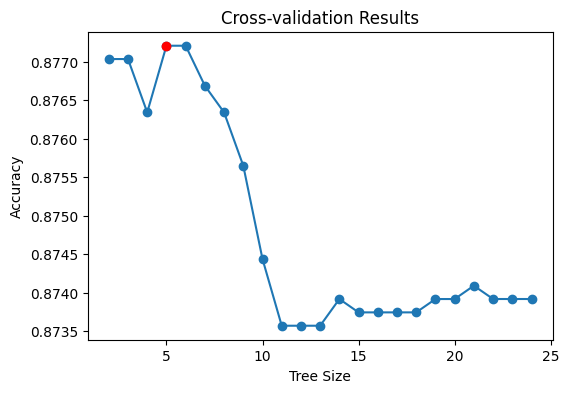

In [ ]:
tree_ = DecisionTreeClassifier(random_state=1)
tree_.fit(X_train, y_train)
params = {'max_leaf_nodes': range(2, 25)}
cv = GridSearchCV(tree_, params, cv=10)
cv.fit(X_train, y_train)
cv_results = cv.cv_results_
best_size = cv.best_params_['max_leaf_nodes']
best_score = cv.best_score_
plt.figure(figsize=(6, 4))
plt.plot(cv_results["param_max_leaf_nodes"], cv_results["mean_test_score"], 'o-')
plt.plot(best_size, best_score, 'ro-')
plt.xlabel('Tree Size')
plt.ylabel('Accuracy')
plt.title('Cross-validation Results');


## Pruned Tree

Pruned Decision Tree Results
Best Parameters: {'max_depth': 5, 'min_samples_leaf': 10}
Accuracy: 0.6424242424242425
Confusion Matrix:
 [[  93   54   45]
 [  47   44   22]
 [ 534  183 1453]]
Classification Report:
               precision    recall  f1-score   support

           0       0.14      0.48      0.21       192
           1       0.16      0.39      0.22       113
           2       0.96      0.67      0.79      2170

    accuracy                           0.64      2475
   macro avg       0.42      0.51      0.41      2475
weighted avg       0.86      0.64      0.72      2475



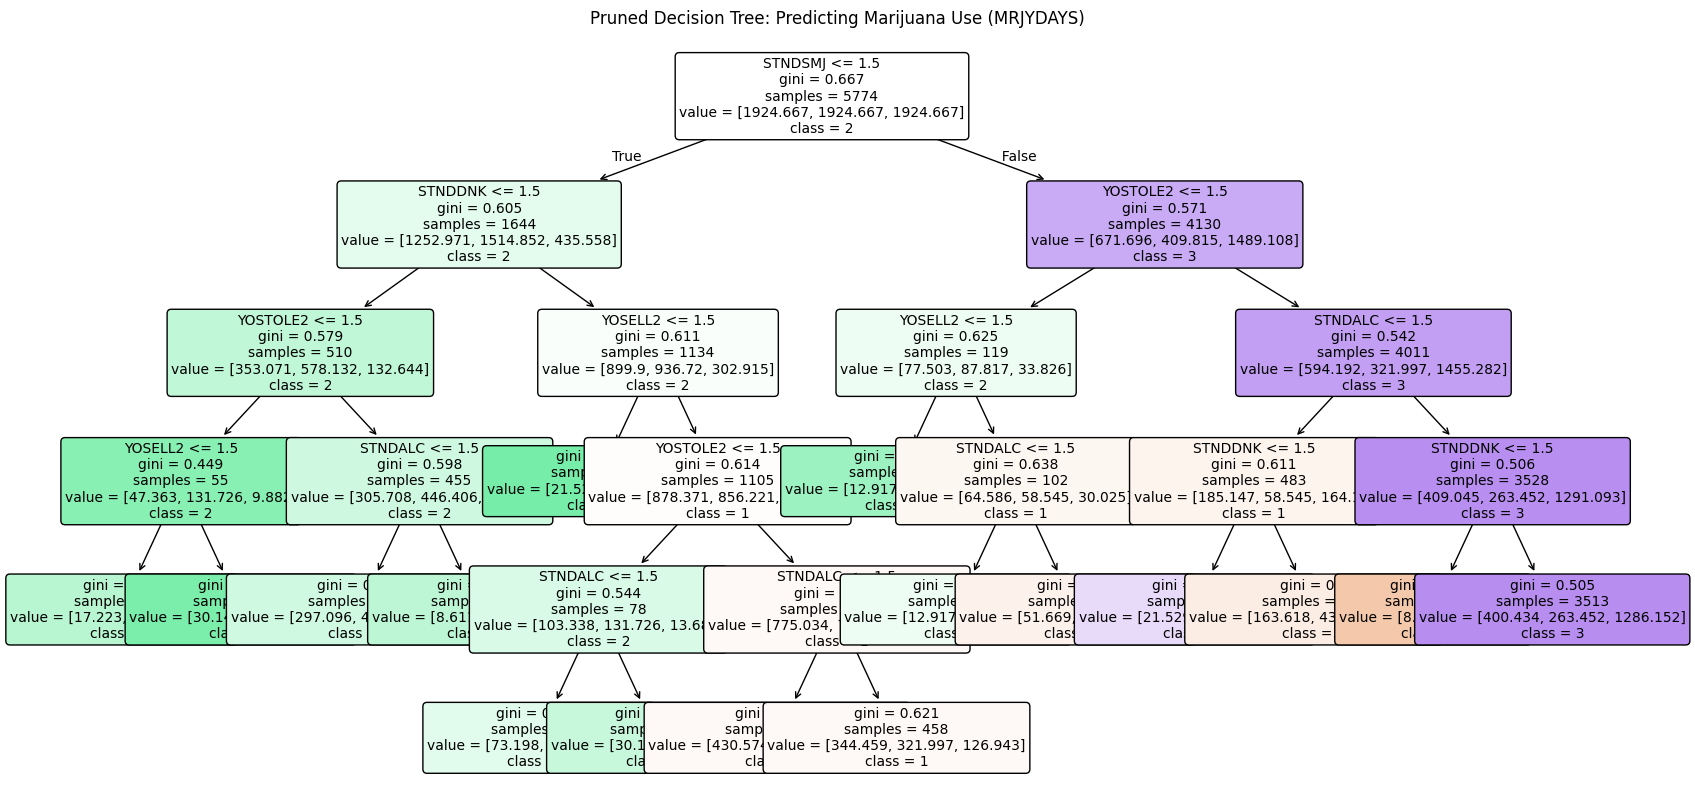

In [ ]:

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=42
)

# === Pruning with GridSearchCV ===
param_grid = {'max_depth': range(5, 15), 'min_samples_leaf': [2,10]}
grid = GridSearchCV(
    DecisionTreeClassifier(random_state=42, class_weight='balanced'),
    param_grid,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1
)
grid.fit(X_train, y_train)

# Best model
best_dt = grid.best_estimator_

# Evaluation
y_pred = best_dt.predict(X_test)

print("Pruned Decision Tree Results")
print("Best Parameters:", grid.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# === Plot the pruned tree ===
class_labels = ['1', '2', '3', '4', '5', '6']

plt.figure(figsize=(20, 10))
plot_tree(
    best_dt,
    feature_names=features,
    class_names=class_labels,
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("Pruned Decision Tree: Predicting Marijuana Use (MRJYDAYS)")
plt.show()


## Random Forest

In [ ]:

# === Random Forest with Grid Search ===
rf_params = {'n_estimators': [100], 'max_depth': [3, 6, 9]}
rf_model = GridSearchCV(
    RandomForestClassifier(random_state=42, class_weight="balanced"),
    param_grid=rf_params,
    scoring='f1',
    cv=5,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

print("\n Random Forest Results")
print("Best Parameters:", rf_model.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan]
  warnings.warn(



 Random Forest Results
Best Parameters: {'max_depth': 3, 'n_estimators': 100}
Accuracy: 0.6452525252525253
Confusion Matrix:
 [[  40  104   48]
 [  20   71   22]
 [ 320  364 1486]]
Classification Report:
               precision    recall  f1-score   support

           0       0.11      0.21      0.14       192
           1       0.13      0.63      0.22       113
           2       0.96      0.68      0.80      2170

    accuracy                           0.65      2475
   macro avg       0.40      0.51      0.39      2475
weighted avg       0.85      0.65      0.72      2475



Majority Class (2 - Heavy):
*   The model is really good at identifying heavy users (class 2).

*   That’s expected because ~88% of your data belongs to this class.


Minority Classes (0 - Light, 1 - Moderate):

*   These are still underperforming.
*   Class 1 has decent recall (63%), but very poor precision (13%) → lots of false positives.

Class 0 is barely being learned.

Overall Accuracy ≈ 64%:



## Gradient Boosting

In [ ]:

# === Gradient Boosting with Grid Search ===
gb_params = {'learning_rate': [0.01, 0.05], 'n_estimators': [50, 100], 'max_depth': [3,7]}
gb_model = GridSearchCV(
    GradientBoostingClassifier(random_state=42),
    param_grid=gb_params,
    scoring='f1_macro',
    cv=5,
    n_jobs=-1
)
gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)

print("\n Gradient Boosting Results")
print("Best Parameters:", gb_model.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred_gb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_gb))
print("Classification Report:\n", classification_report(y_test, y_pred_gb))


 Gradient Boosting Results
Best Parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}
Accuracy: 0.877979797979798
Confusion Matrix:
 [[   0    7  185]
 [   0   11  102]
 [   1    7 2162]]
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       192
           1       0.44      0.10      0.16       113
           2       0.88      1.00      0.94      2170

    accuracy                           0.88      2475
   macro avg       0.44      0.36      0.37      2475
weighted avg       0.79      0.88      0.83      2475



Model predicts Heavy use (2) very well
Performs poorly on Light (0) and Moderate (1) categories:

Almost all are misclassified as Heavy

Class 0: 0% recall, 0% precision

Improvement Using Class Weights

This approach ensures your model pays more attention to minority classes during training — a smart fix for your previous imbalance problem.

In [ ]:
from sklearn.utils.class_weight import compute_sample_weight
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)


In [ ]:
gb_model = GridSearchCV(
    GradientBoostingClassifier(random_state=42),
    param_grid=gb_params,
    scoring='f1_macro',
    cv=5,
    n_jobs=-1
)
gb_model.fit(X_train, y_train, sample_weight=sample_weights)  # <- okay for grid search


GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05], 'max_depth': [3, 7],
                         'n_estimators': [50, 100]},
             scoring='f1_macro')

In [ ]:

y_pred_bal = gb_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred_bal))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_bal))
print("Classification Report:\n", classification_report(y_test, y_pred_bal))


Accuracy: 0.6424242424242425
Confusion Matrix:
 [[  95   52   45]
 [  49   43   21]
 [ 542  176 1452]]
Classification Report:
               precision    recall  f1-score   support

           0       0.14      0.49      0.22       192
           1       0.16      0.38      0.22       113
           2       0.96      0.67      0.79      2170

    accuracy                           0.64      2475
   macro avg       0.42      0.51      0.41      2475
weighted avg       0.86      0.64      0.72      2475



Earlier the accuracy was 88% accuracy which sounds good — but it’s just predicting the majority class. (class imbalance issue)

After improving the class weight the accuracy dropped slightly to 64%, but that’s expected — the model is no longer just optimizing for the majority class.

Class 0 and 1 now have much better recall, meaning the model is catching more true instances of minority classes.


## Bagging

In [ ]:
# Fit Bagging model (Random Forest)
bagging_model = RandomForestClassifier(
    max_features=X_train.shape[1],
    n_estimators=25,
    random_state=1,
    class_weight="balanced"
)

bagging_model.fit(X_train, y_train)

# Standard predictions (no thresholding)
y_pred = bagging_model.predict(X_test)

# Evaluation
print("Mean Squared Error: {:.2f}".format(mean_squared_error(y_test, y_pred)))
print("Training score: {:.2f}%".format(bagging_model.score(X_train, y_train) * 100))
print("Test score: {:.2f}%".format(bagging_model.score(X_test, y_test) * 100))

# Classification report
from sklearn.metrics import classification_report, confusion_matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Mean Squared Error: 1.07
Training score: 66.11%
Test score: 64.28%
Confusion Matrix:
 [[  95   51   46]
 [  48   41   24]
 [ 540  175 1455]]
Classification Report:
               precision    recall  f1-score   support

           0       0.14      0.49      0.22       192
           1       0.15      0.36      0.22       113
           2       0.95      0.67      0.79      2170

    accuracy                           0.64      2475
   macro avg       0.42      0.51      0.41      2475
weighted avg       0.85      0.64      0.72      2475



# Regression

To what extent do behaviors such as physical fights (YOFIGHT2), group fights (YOGRPFT2), theft (YOSTOLE2), communication problems with parents or peers (TALKPROB), and violent attacks (YOATTAK2) predict the age of first alcohol use (IRALCAGE)?"



In [ ]:
required_columns =  youth_experience_cols + ['IRALCAGE']
df_r = df[required_columns]
print(df_r.shape)

(8249, 48)


Keeps only respondents who started drinking at age 7 or older, and

Removes those who never drank alcohol.

In [ ]:
df_r = df_r[df_r['IRALCAGE'] >= 7]
df_r.shape


(8198, 48)

In [ ]:
df_r = df_r[df_r['IRALCAGE'] != 991]
df_r.shape


(1999, 48)

# Finding Correlation among variables

In [ ]:

df_corr = df_youth.copy()
df_corr["IRALCAGE"] = df_r["IRALCAGE"]

# Step 2: Encode all categorical variables
df_corr = df_corr.apply(lambda col: pd.factorize(col)[0] if col.dtypes == 'object' or col.dtypes.name == 'category' else col)

# Step 3: Compute correlations
correlations = df_corr.corr()["IRALCAGE"].drop("IRALCAGE").sort_values(ascending=False)

# Step 4: Display top and bottom correlations
print("\n Top correlated features with IRALCAGE:")
print(correlations.head(10))

print("\n Least correlated features with IRALCAGE:")
print(correlations.tail(10))



 Top correlated features with IRALCAGE:
YOFIGHT2    0.179150
YOGRPFT2    0.158445
YOSTOLE2    0.142170
TALKPROB    0.132383
YOATTAK2    0.119902
YOHGUN2     0.097216
YOSELL2     0.068749
PREVIOL2    0.065054
STNDSCIG    0.056995
AVGGRADE    0.056905
Name: IRALCAGE, dtype: float64

 Least correlated features with IRALCAGE:
PRALDLY2   -0.065427
FRDADLY2   -0.066509
YFLADLY2   -0.067797
PRGDJOB2   -0.075463
SCHFELT    -0.079017
TCHGJOB    -0.096282
PRPROUD2   -0.099582
YFLPKCG2   -0.110729
ARGUPAR    -0.127770
STNDALC    -0.134133
Name: IRALCAGE, dtype: float64


In [ ]:
strong_correlations = correlations[correlations > 0.10]
strong_correlations

,IRALCAGE
YOFIGHT2,0.179150
YOGRPFT2,0.158445
YOSTOLE2,0.142170
TALKPROB,0.132383
YOATTAK2,0.119902


In [ ]:

# === Define features ===
features = ['YOFIGHT2', 'YOGRPFT2','YOSTOLE2','TALKPROB','YOATTAK2']

# === Target variable ===
target = 'IRALCAGE'

# === Drop rows with missing values in selected features or target ===
df_model = df_r[features + [target]].dropna()

# === Convert to numeric if needed (factorization for categorical) ===
for col in features:
    if df_model[col].dtype == 'object':
        df_model[col] = pd.factorize(df_model[col])[0]

# === Define X and y ===
X = df_model[features]
y = df_model[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeRegressor

In [ ]:
tree = DecisionTreeRegressor(random_state = 1)
tree.fit(X_train,y_train)
MSE = ((y_test - tree.predict(X_test))**2).mean()
print(MSE)


3.7181749555899812


In [ ]:
importance = pd.DataFrame({'feature': X_train.columns, 'importance': tree.feature_importances_}).sort_values('importance', ascending=False)
importance.head(10)

,feature,importance
0,YOFIGHT2,0.385566
3,TALKPROB,0.250778
4,YOATTAK2,0.151767
2,YOSTOLE2,0.108883
1,YOGRPFT2,0.103006


## Pruning

Best tree size:  7


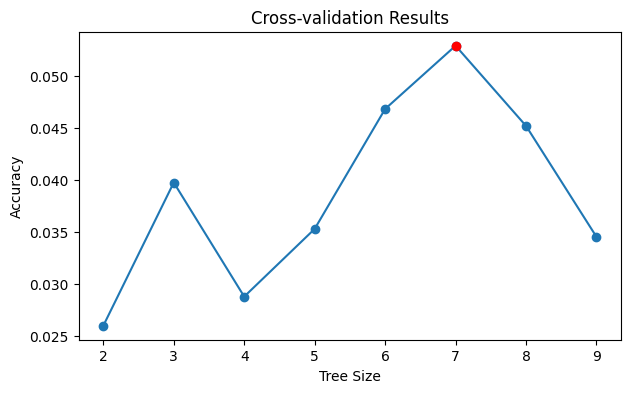

In [ ]:
tree1 = DecisionTreeRegressor(random_state = 1)
tree1.fit(X_train, y_train)
params = {'max_leaf_nodes': range(2, 10)}
cv_tree1 = GridSearchCV(tree1, params, cv=20)
cv_tree1.fit(X_train, y_train)
cv_results = cv_tree1.cv_results_
best_size = cv_tree1.best_params_['max_leaf_nodes']
best_score = cv_tree1.best_score_
print('Best tree size: ',best_size)

plt.figure(figsize=(7, 4))
plt.plot(cv_results["param_max_leaf_nodes"].data, cv_results["mean_test_score"], 'o-')
plt.plot(best_size, best_score, 'ro-')
plt.xlabel('Tree Size')
plt.ylabel('Accuracy')
plt.title('Cross-validation Results');


In [ ]:
prune_tree = DecisionTreeRegressor(random_state = 1, max_leaf_nodes = best_size)
prune_tree.fit(X_train, y_train)
MSE = ((y_test - prune_tree.predict(X_test))**2).mean()
print(MSE)


3.850847844182863


In [ ]:
importances = pd.DataFrame({'feature': X_train.columns, 'importance': prune_tree.feature_importances_}).sort_values('importance', ascending=False)
importances.head(10)

,feature,importance
0,YOFIGHT2,0.481981
3,TALKPROB,0.285728
2,YOSTOLE2,0.091988
1,YOGRPFT2,0.089232
4,YOATTAK2,0.051071


## Random Forest


In [ ]:
rf_reg = RandomForestRegressor(max_features=20 , random_state = 1)
rf_reg.fit(X_train,y_train)
y_pred_rf = rf_reg.predict(X_test)
print("Mean Squared Error: {:.2f}".format(mean_squared_error(y_test, y_pred_rf)))

Mean Squared Error: 3.72


In [ ]:
importances = pd.DataFrame({'feature': X_train.columns, 'importance': rf_reg.feature_importances_}).sort_values('importance', ascending=False)
importances.head(10)

,feature,importance
0,YOFIGHT2,0.322629
3,TALKPROB,0.226512
1,YOGRPFT2,0.159739
2,YOSTOLE2,0.152094
4,YOATTAK2,0.139026


## Boosting

In [ ]:
boost_reg = GradientBoostingRegressor(n_estimators=100, max_depth=4
 , random_state=1)
boost_reg.fit(X_train, y_train)
y_pred_boost = boost_reg.predict(X_test)
# find the MSE
print("Mean Squared Error: {:.2f}".format(mean_squared_error(y_test, y_pred_boost)))

Mean Squared Error: 3.75


In [ ]:
importances = pd.DataFrame({'feature': X_train.columns, 'importance': boost_reg.feature_importances_}).sort_values('importance', ascending=False)
importances.head(10)

,feature,importance
0,YOFIGHT2,0.385183
3,TALKPROB,0.238217
4,YOATTAK2,0.133792
1,YOGRPFT2,0.132508
2,YOSTOLE2,0.110300


## Bagging

In [ ]:
boston_bagging = RandomForestRegressor(max_features=X_train.shape[1],random_state = 1,n_estimators=25)
boston_bagging.fit(X_train,y_train)

print("Number of trees:", boston_bagging.n_estimators)
print("Number of features tried at each split:",boston_bagging.max_features)
print("Training score: {:.2f}%".format(boston_bagging.score(X_train,y_train)*100))

Number of trees: 25
Number of features tried at each split: 5
Training score: 8.83%


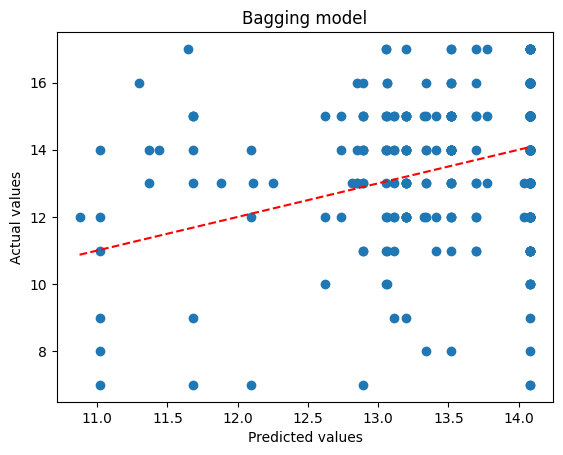

In [ ]:
# Predict values
y_pred_bag = boston_bagging.predict(X_test)

# plot predicted vs actual values
plt.scatter(y_pred_bag, y_test)
plt.plot([min(y_pred_bag), max(y_pred_bag)], [min(y_pred_bag), max(y_pred_bag)], 'r--')
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.title('Bagging model');

In [ ]:
# find the MSE
print("Mean Squared Error: {:.2f}".format(mean_squared_error(y_test, y_pred_bag)))

Mean Squared Error: 3.74


The test set MSE associated with the bagged regression tree is 3.74

# Results Interpretation

1. Binary Classification – Predicting Marijuana Use (MRJFLAG)
  1.1 Decision Tree
      *   Accuracy: ~74.6%
      *   Recall (Users): 78%
      *   Precision (Users): 37%

  Insight:

      Decent recall shows it's catching many of the actual users, which is good for interventions. However, low precision indicates a high number of false positives (non-users predicted as users).

  1.2 Pruned Tree
    * Accuracy: ~78%

    * Precision (Users): 40%

    * Recall (Users): 74%

  Insight:
    
  Pruning helped balance model complexity and performance. It reduced overfitting and improved interpretability while maintaining good recall and accuracy.

  1.3 Random Forest
    * Accuracy: ~84%

    * Precision (Users): 51%

    * Recall (Users): 44%

  Insight:

  Overall a robust performer. Slight drop in recall compared to decision tree, but precision improved. Still misses many users (low recall).

  1.4 Gradient Boosting
  * Accuracy: ~84%

  * Precision (Users): 51%

  * Recall (Users): 43%

  Insight:

  Similar performance to Random Forest. Boosting is typically better at handling subtle patterns, but here it doesn’t drastically outperform RF.


  1.5 Bagging

  * Accuracy : ~ 74%

  * Precision (Users) : 36%

  * Recall (Users) : 77%
  
  
  Insight:



2. Multi-Class Classification – Predicting Frequency of Marijuana Use (MRJYDAYS)
(Target grouped as Light, Moderate, Heavy)

  2.1 Decision Tree
  * Accuracy: ~64%
  *Heavy Users:
  *Precision: 96%
  * Recall: 67%

  Light & Moderate Users: Very low precision & recall (under 15%)

  Insight:
  
  The model is biased toward majority class (Heavy) due to class imbalance (~88% of data). Not helpful for detecting early/mild users.

  2.2 Pruned Tree
  * Accuracy: ~60%

  * Macro F1: ~0.23 (poor across classes)

  Insight:

  Slight improvement in balance. Class 5 (moderate users) somewhat better identified. Still heavily favors heavy users. Recall improved, but model still weak on light/moderate detection.

  2.3 Random Forest

    * Accuracy: ~64.5%
    * Class 1 Recall: 63% (best among minority classes)
    * Precision remains low

  Insight:

  Better at capturing moderate users, but still low confidence in predictions (low precision). Heavy class dominates due to imbalance.

  2.4 Gradient Boosting

  * Accuracy: ~87.6% (BUT: Predicts only the majority class (Heavy) for all instances.)

  * Precision/Recall (Light & Moderate): 0

  Insight:
  This is a classic accuracy trap — the model learns to always predict the dominant class to maximize accuracy. Completely fails for light/moderate users.

  2.5 Bagging

  * Accuracy : 64%
  * Precision/Recall (The model predicts class 2 (the majority class) most of the time. Class 0 and 1 are being heavily misclassified) only 49% of class 0 is correctly predicted, only 38% of class 1 is correctly predicted but for class 2 67% is correctly predicited

3. Regression – Predicting Age of First Alcohol Use (IRALCAGE)

3.1 Decision Tree
  
  * MSE: ~3.72

Top Features: TALKPROB, YOGRPFT2, YOATTAK2

Insight:
Simple model with reasonable performance. Shows that interpersonal issues are somewhat predictive of earlier alcohol use, but the signal is weak/moderate.

3.3 Pruned Tree

* MSE: ~3.85

Insight:
Slightly higher error, but better generalization. Sacrifices a bit of precision for robustness and interpretability.

3.5 Random Forest

* MSE: ~3.72

Top Feature: TALKPROB

Insight:
Matches unpruned tree’s performance. Captures non-linear patterns, but interpretability drops. Feature importances show consistent signal with decision tree.

3.5 Gradient Boosting

* MSE: ~3.75

Insight:
Comparable to others. Could benefit from hyperparameter tuning. Works best when more granular, high-signal features are present

# Overall Summary

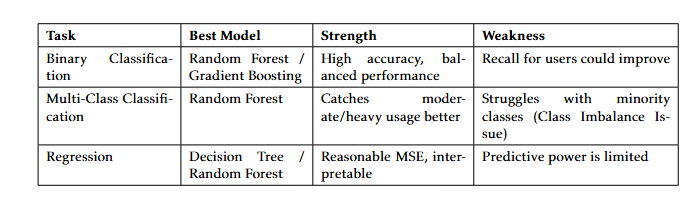